![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# Computing highly accurate mass transfer at rising bubbles

In this notebook, we cover the following topics:

- The high Schmidt number problem  
- Decoupling two-phase flow and mass transfer  
- Two-phase flow simulation of a single rising bubble  
- Data processing and visualization  
- Model creation  
  - Rise velocity  
  - Surface velocity  
  - Bubble radius  
  - Model export  
- Single-phase flow simulation with mass transfer  

## The high Schmidt number problem

## Decoupling two-phase flow and mass transfer

## Data processing and visualization

In [1]:
from typing import List, Tuple
from glob import glob
from os.path import isdir, join
from copy import deepcopy
import matplotlib.pyplot as plt
import torch as pt
import numpy as np
from pandas import DataFrame, read_csv, to_numeric
from lecture_utils import train_model, create_simple_network

# increase plot resolution
plt.rcParams["figure.dpi"] = 160

# dataset directory
data = "../datasets/ellipsoidal_bubble"

# set default dtype to double precision
pt.set_default_dtype(pt.float64)

# make results reproducible
pt.manual_seed(0)

# create output directory
output = "output"
!mkdir -p $output

In [2]:
def load_logfile(path: str) -> DataFrame:
    columns = ["t", "vol", "x", "y", "z", "ux", "uy", "uz", "area"]
    log = read_csv(path, sep="\s+", header=None, names=columns, on_bad_lines="skip").dropna()
    log = log[to_numeric(log.t, errors="coerce").isnull() == False].reset_index(drop=True)
    return log.apply(to_numeric)

log = load_logfile(join(data, "log.solver"))
log.head()

,t,vol,x,y,z,ux,uy,uz,area
0,0.000000,0.083315,3.500000,0.294497,0.0,0.000000,0.000000,0.0,1.570654
1,0.001045,0.083308,3.500011,0.292478,0.0,0.002986,0.000113,0.0,1.572102
2,0.002477,0.083306,3.500008,0.292458,0.0,0.005118,-0.000109,0.0,1.571829
3,0.004044,0.083307,3.500015,0.292159,0.0,0.008566,-0.000015,0.0,1.571621
4,0.005663,0.083308,3.500029,0.292319,0.0,0.011656,-0.000133,0.0,1.571783


In [3]:
write_times = pt.arange(0.0, 15, 0.15)
xc = pt.zeros_like(write_times)
uxc = pt.zeros_like(write_times)
for i, t in enumerate(write_times):
    row = log.iloc[(log.t-t.item()).abs().argsort()[0]]
    xc[i] = row.x
    uxc[i] = row.ux

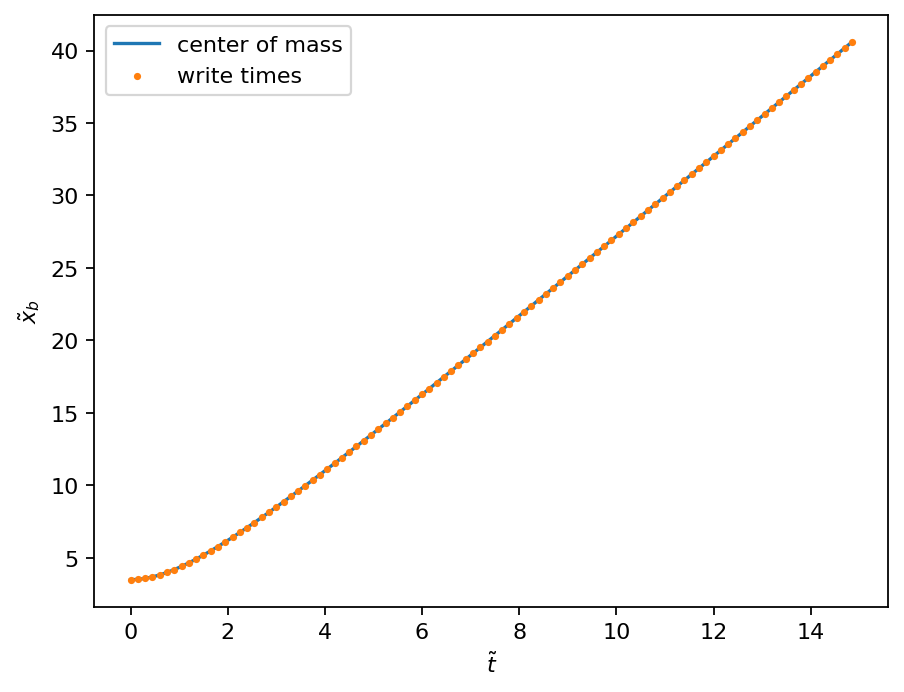

In [4]:
plt.plot(log.t, log.x, label="center of mass")
plt.scatter(write_times, xc, s=5, c="C1", label="write times", zorder=5)
plt.legend()
plt.xlabel(r"$\tilde{t}$")
plt.ylabel(r"$\tilde{x}_b$")
plt.savefig(join(output, "bubble_position.svg"), bbox_inches="tight")

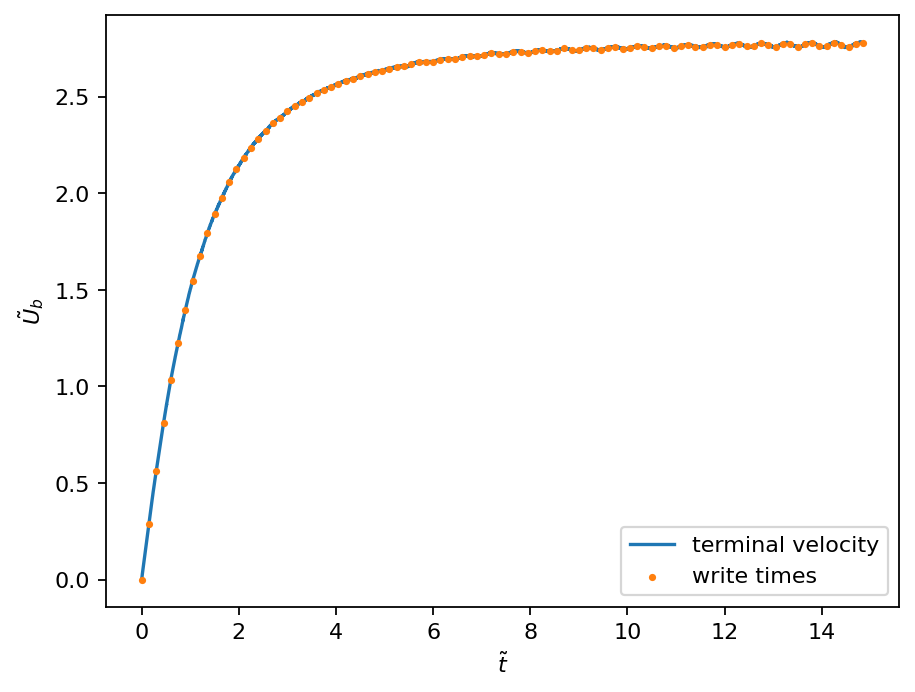

In [5]:
plt.plot(log.t, log.ux, label="terminal velocity")
plt.scatter(write_times, uxc, s=5, c="C1", label="write times", zorder=5)
plt.legend()
plt.xlabel(r"$\tilde{t}$")
plt.ylabel(r"$\tilde{U}_b$")
plt.savefig(join(output, "bubble_speed.svg"), bbox_inches="tight")

In [6]:
files = glob(join(data, r"plic/*"))
print(files[:2])
iterations = sorted(set([name.split("_")[-2] for name in files]), key=int)
assert len(iterations) == 100, "expected exactly 100 snapshots"

['../datasets/ellipsoidal_bubble/plic/points_000067_n002.txt', '../datasets/ellipsoidal_bubble/plic/points_000024_n003.txt']


In [7]:
def parse_processor_file(path: str) -> pt.Tensor:
    with open(path, "r") as f:
        lines = [list(map(float, line.strip().split(" "))) for line in f if line.strip()]
    return pt.tensor(lines)

parse_processor_file(files[0])[:2]

tensor([[ 2.6985e+01,  0.0000e+00,  9.9568e-01, -4.3208e-03,  2.7620e+00,
          0.0000e+00],
        [ 2.6986e+01,  7.3242e-03,  9.9568e-01, -4.3208e-03,  2.7636e+00,
         -1.1328e-02]])

In [8]:
def load_interface_snapshot(path: str, iteration: int, np: int) -> pt.Tensor:
    p_data = []
    for p in range(np):
        p_data.append(
            parse_processor_file(f"{path}points_{iteration:06d}_n{p:03d}.txt")
        )
    p_data = pt.cat(p_data)
    return p_data[p_data[:, -1].abs() < 10]

load_interface_snapshot(join(data, "plic/"), 0, 4).shape

torch.Size([276, 6])

In [9]:
if_data = [load_interface_snapshot(join(data, "plic/"), int(i), 4) for i in iterations]
for i, (xc_i, ub_i) in enumerate(zip(xc, uxc)):
    if_data[i][:, 0] -= xc_i  # make position relative
    if_data[i][:, 4] -= ub_i  # make velocity relative
    if_data[i][:, 2:4] /= if_data[i][:, 2:4].norm(dim=-1).unsqueeze(-1)

In [10]:
def convert_to_polar(xy: pt.Tensor) -> pt.Tensor:
    rphi = pt.zeros_like(xy)
    rphi[:, 0] = xy.norm(dim=1)
    rphi[:, 1] = pt.asin(xy[:, 1]/rphi[:, 0])
    rphi[xy[:, 0] < 0.0, 1] = np.pi - rphi[xy[:, 0] < 0.0, 1]
    return rphi

shape_polar = [convert_to_polar(i[:, :2]) for i in if_data]

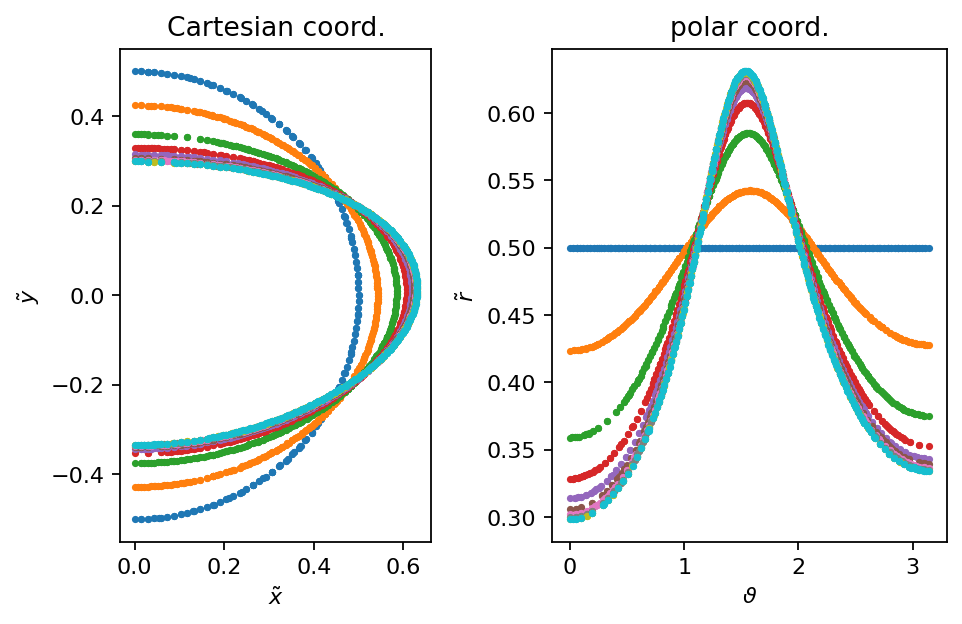

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))
for i, (shape_xy, shape_rphi) in enumerate(zip(if_data[::10], shape_polar[::10])):
    ax1.scatter(shape_xy[:, 1], shape_xy[:, 0], s=5)
    ax2.scatter(shape_rphi[:, 1], shape_rphi[:, 0], s=5)
    ax1.set_aspect("equal")

ax1.set_xlabel(r"$\tilde{x}$")
ax1.set_ylabel(r"$\tilde{y}$")
ax2.set_xlabel(r"$\vartheta$")
ax2.set_ylabel(r"$\tilde{r}$")
ax1.set_title("Cartesian coord.")
ax2.set_title("polar coord.")
plt.savefig(join(output, "shape_over_time.svg"), bbox_inches="tight")

In [12]:
def project_velocity(normal: pt.Tensor, velocity: pt.Tensor):
    vn = -(velocity * normal).sum(dim=1)
    tangential = pt.zeros_like(normal)
    tangential[:, 0] = normal[:, 1]
    tangential[:, 1] = -normal[:, 0]
    vt = (velocity * tangential).sum(dim=1)
    return pt.stack((vn, vt)).T

projected_velocity = [project_velocity(i[:, 2:4], i[:, 4:]) for i in if_data]

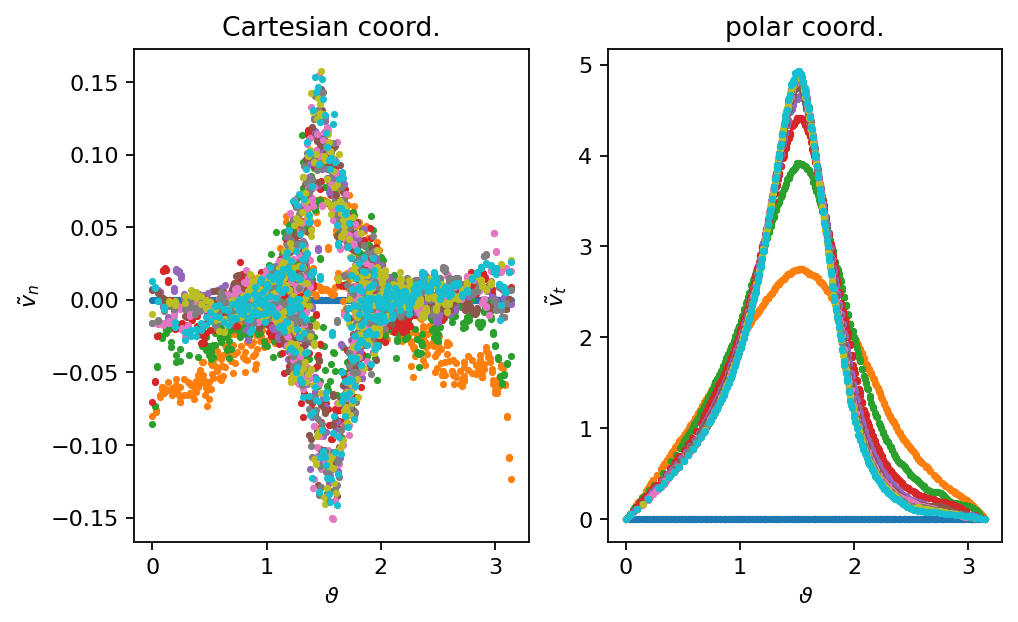

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))
for i, (rphi, vel) in enumerate(zip(shape_polar[::10], projected_velocity[::10])):
    ax1.scatter(rphi[:, 1], vel[:, 0], s=5)
    ax2.scatter(rphi[:, 1], vel[:, 1], s=5)

ax1.set_xlabel(r"$\vartheta$")
ax1.set_ylabel(r"$\tilde{v}_n$")
ax2.set_xlabel(r"$\vartheta$")
ax2.set_ylabel(r"$\tilde{v}_t$")
ax1.set_title("Cartesian coord.")
ax2.set_title("polar coord.")
plt.savefig(join(output, "velocity_projected_over_time.svg"), bbox_inches="tight")

## Model creation

### Rise velocity

In [14]:
rv_max = uxc.max()
rv_min = pt.zeros_like(rv_max)
rv_norm = (uxc - rv_min) / (rv_max - rv_min)
wt_max = write_times.max()
wt_min = pt.zeros_like(wt_max)
wt_norm = (write_times - wt_min) / (wt_max - wt_min)
rv_dataset = pt.utils.data.TensorDataset(wt_norm.unsqueeze(-1), rv_norm.unsqueeze(-1))

In [15]:
def split_and_train(dataset, model, epochs, batch_size=None, lr_min=1.0e-4, lr_max=1.0e-2, train_frac=0.9, patience=20):
    n_train = int(len(dataset)*train_frac)
    n_val = len(dataset) - n_train
    batch_size = n_train if batch_size is None else batch_size
    train, val = pt.utils.data.random_split(dataset, (n_train, n_val))
    train_loader = pt.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = pt.utils.data.DataLoader(val, batch_size=len(val))
    optimizer = pt.optim.AdamW(model.parameters(), lr=lr_max)
    scheduler = pt.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.5, patience=patience, min_lr=lr_min)
    results = train_model(
        model,
        pt.nn.MSELoss(),
        train_loader, val_loader,
        epochs=epochs,
        lr_schedule=scheduler,
        optimizer=optimizer
    )
    return model, results

In [16]:
class RVModelNorm(pt.nn.Module):
    def __init__(self, n_neurons=100, n_hidden=2, activation=pt.nn.Tanh):
        super(RVModelNorm, self).__init__()
        self._model = create_simple_network(1, 1, n_neurons, n_hidden, activation)

    def forward(self, x):
        return self._model(x) * x

In [17]:
best_val_loss = float("inf")

for k in range(5):
    pt.manual_seed(k)
    model = RVModelNorm()
    model, results = split_and_train(rv_dataset, model, 500, 20)
    if results["val_loss"].values[-1] < best_val_loss:
        best_val_loss = results["val_loss"].values[-1]
        print(f"\nBest validation loss decreased to {best_val_loss:2.4e}")
        best_rv_model_norm = deepcopy(model)
        best_results_rv = deepcopy(results)

 Epoch  499/499 - Training loss: 6.135854e-05; Validation loss: 8.702406e-06
Best validation loss decreased to 8.7024e-06
 Epoch  499/499 - Training loss: 1.132306e-04; Validation loss: 1.414502e-06
Best validation loss decreased to 1.4145e-06
 Epoch  499/499 - Training loss: 6.099338e-05; Validation loss: 1.118540e-04

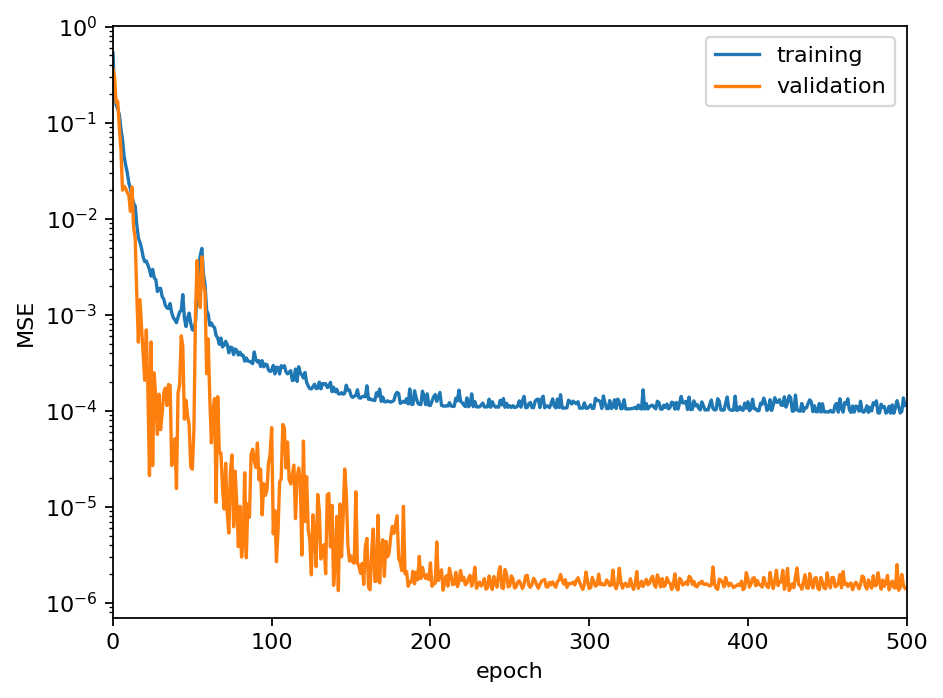

In [18]:
plt.plot(best_results_rv["epoch"], best_results_rv["train_loss"], label="training")
plt.plot(best_results_rv["epoch"], best_results_rv["val_loss"], label="validation")

plt.xlabel("epoch")
plt.ylabel("MSE")
plt.yscale("log")
plt.legend()
plt.xlim(0, 500)
plt.savefig(join(output, "rv_mse_loss.svg"), bbox_inches="tight")

In [19]:
class RVModel(pt.nn.Module):
    def __init__(self, rv_model_norm, rv_min, rm_max, t_min, t_max):
        super(RVModel, self).__init__()
        self._model = rv_model_norm
        self._rv_min = rv_min
        self._rv_max = rv_max
        self._t_min = t_min
        self._t_max = t_max

    def forward(self, x):
        x_norm = (x.unsqueeze(1) - self._t_min) / (self._t_max - self._t_min)
        rv_norm = self._model(x_norm)
        return (rv_norm * (self._rv_max - self._rv_min) + self._rv_min).squeeze()

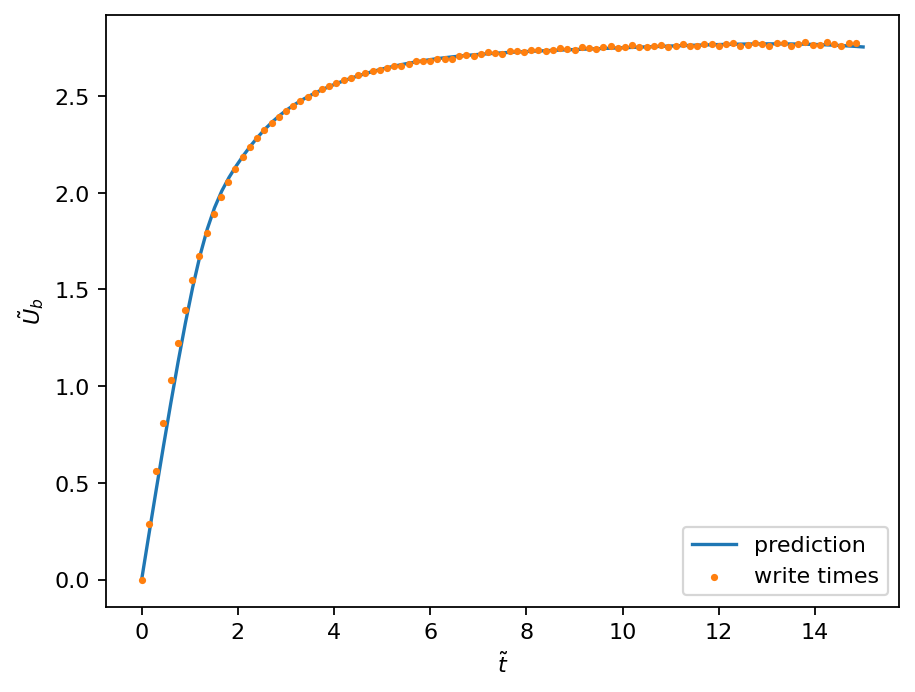

In [20]:
rv_model = RVModel(best_rv_model_norm, rv_min, rv_max, wt_min, wt_max)
t_plot = pt.linspace(0.0, 15.0, 100)
rv_pred = rv_model(t_plot).detach()
plt.plot(t_plot, rv_pred, label="prediction")
plt.scatter(write_times, uxc, s=5, c="C1", label="write times", zorder=5)
plt.legend()
plt.xlabel(r"$\tilde{t}$")
plt.ylabel(r"$\tilde{U}_b$")
plt.savefig(join(output, "rv_prediction.svg"), bbox_inches="tight")

### Surface velocity

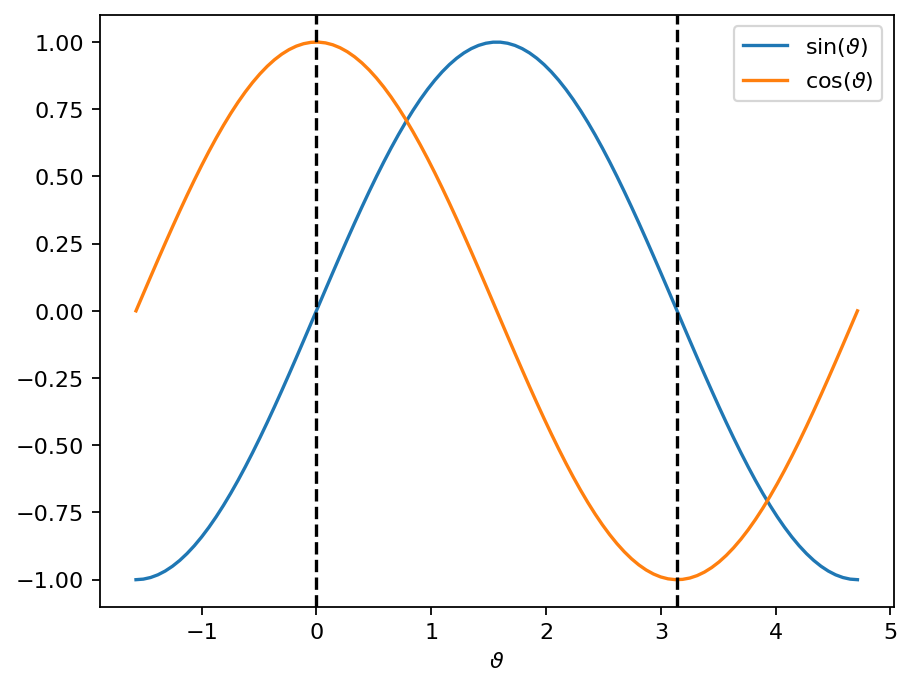

In [21]:
phi = pt.linspace(-np.pi/2, 1.5*np.pi, 100)
plt.plot(phi, phi.sin(), label=r"$\mathrm{sin}(\vartheta)$")
plt.plot(phi, phi.cos(), label=r"$\mathrm{cos}(\vartheta)$")
plt.xlabel(r"$\vartheta$")
plt.legend()
plt.axvline(0.0, ls="--", c="k")
plt.axvline(np.pi, ls="--", c="k")
plt.savefig(join(output, "sin_symmetry.svg"), bbox_inches="tight")

In [22]:
def reshape_surface_data(theta, field, time):
    dataset = []
    for i in range(len(theta)):
        n_points = len(theta[i])
        data_i = pt.zeros((n_points, 3))
        data_i[:, 0] = theta[i]
        data_i[:, 1] = time[i]
        data_i[:, 2] = field[i]
        dataset.append(data_i)
    return pt.cat(dataset, dim=0)

In [23]:
theta = [data[:, 1] for data in shape_polar]
vel = [data[:, 1] for data in projected_velocity]
tv_data = reshape_surface_data(theta, vel, write_times)
tv_max = tv_data[:, 1:].max(dim=0).values
tv_min = pt.zeros_like(tv_max)
tv_norm = pt.zeros_like(tv_data)
tv_norm[:, 0] = tv_data[:, 0]
tv_norm[:, 1:] = (tv_data[:, 1:] - tv_min) / (tv_max - tv_min)
tv_dataset = pt.utils.data.TensorDataset(tv_norm[:, :2], tv_norm[:, 2].unsqueeze(-1))
len(tv_dataset)

47465

In [24]:
class TVVelocityNorm(pt.nn.Module):
    def __init__(self, n_neurons=100, n_hidden=5, activation=pt.nn.ReLU):
        super(TVVelocityNorm, self).__init__()
        self._model_norm = create_simple_network(2, 1, n_neurons, n_hidden, activation)

    def forward(self, x):
        sin = pt.sin(x[:, 0]).unsqueeze(-1)
        x = pt.stack((pt.cos(x[:, 0]), x[:, 1])).T
        return self._model_norm(x) * sin * x[:, 1].unsqueeze(-1)

In [25]:
best_val_loss = float("inf")

for k in range(1):
    pt.manual_seed(k)
    model = TVVelocityNorm()
    model, results = split_and_train(tv_dataset, model, 50, 500, patience=1)
    if results["val_loss"].values[-1] < best_val_loss:
        best_val_loss = results["val_loss"].values[-1]
        print(f"\nBest validation loss decreased to {best_val_loss:2.4e}")
        best_tv_model_norm = deepcopy(model)
        best_results_tv = deepcopy(results)

 Epoch   49/49 - Training loss: 1.781350e-05; Validation loss: 1.865229e-05
Best validation loss decreased to 1.8652e-05


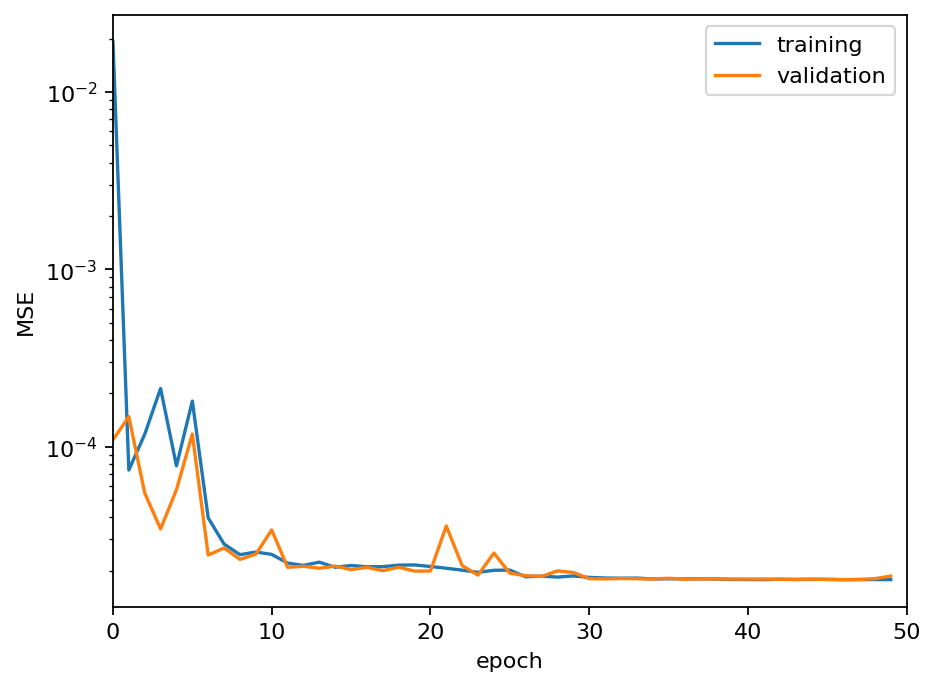

In [26]:
plt.plot(best_results_tv["epoch"], best_results_tv["train_loss"], label="training")
plt.plot(best_results_tv["epoch"], best_results_tv["val_loss"], label="validation")

plt.xlabel("epoch")
plt.ylabel("MSE")
plt.yscale("log")
plt.legend()
plt.xlim(0, 50)
plt.savefig(join(output, "tv_mse_loss.svg"), bbox_inches="tight")

In [27]:
class TVVelocity(pt.nn.Module):
    def __init__(self, model_norm, t_min, t_max, tv_min, tv_max):
        super(TVVelocity, self).__init__()
        self._model = model_norm
        self._t_min = t_min
        self._t_max = t_max
        self._tv_min = tv_min
        self._tv_max = tv_max

    def forward(self, x):
        x_norm = pt.zeros_like(x)
        x_norm[:, 0] = x[:, 0]
        x_norm[:, 1] = (x[:, 1] - self._t_min) / (self._t_max - self._t_min)
        y_norm = self._model(x_norm)
        return (y_norm * (self._tv_max - self._tv_min) + self._tv_min).squeeze()

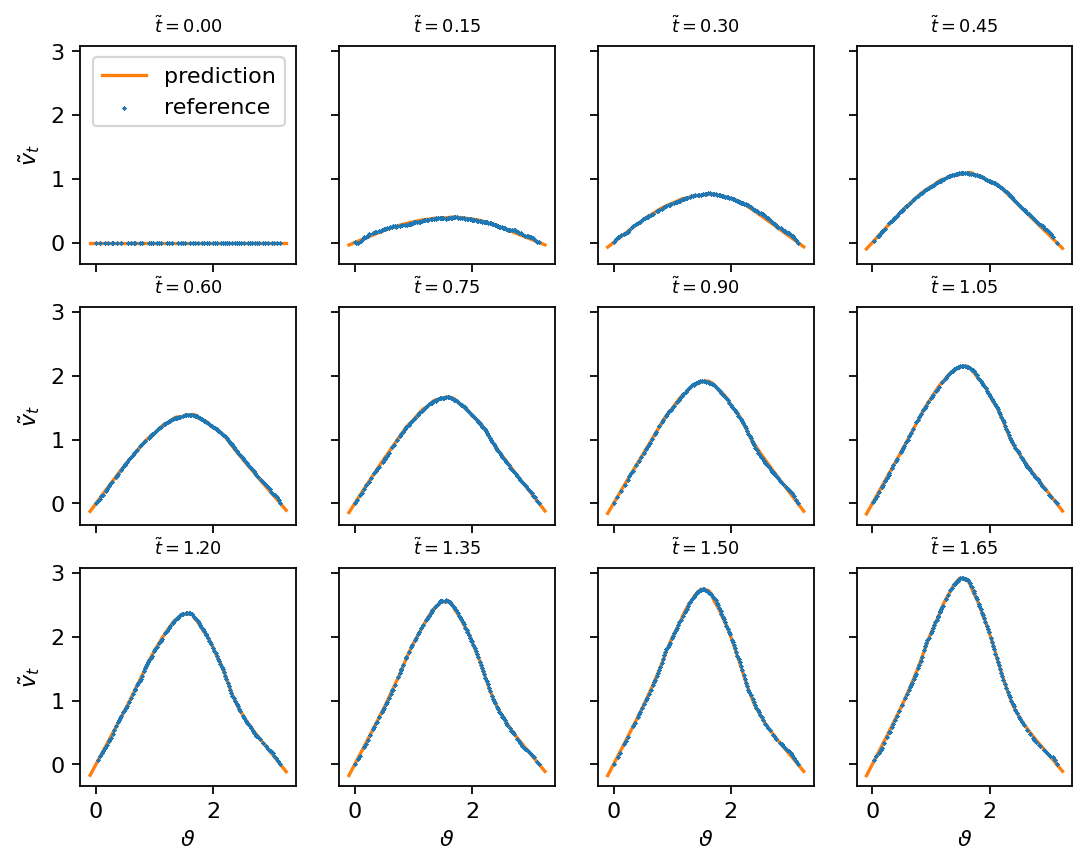

In [28]:
tv_model = TVVelocity(best_tv_model_norm, tv_min[0], tv_max[0], tv_min[1], tv_max[1])
f = pt.zeros(100, 2)
f[:, 0] = pt.linspace(-0.1, np.pi+0.1, 100)
idx = list(range(0, 12, 1))
n_rows = len(idx) / 4 if len(idx) % 4 == 0 else len(idx) / 4 + 1
fig, axarr = plt.subplots(int(n_rows), 4, figsize=(8, n_rows*2), sharex=True, sharey=True)
row, col = 0, 0
for i in idx:
    f[:, 1] = write_times[i]
    vel_i = tv_model(f).detach()
    axarr[row, col].plot(f[:, 0], vel_i, c="C1", label="prediction")
    axarr[row, col].scatter(shape_polar[i][::4, 1], projected_velocity[i][::4, 1], marker="x", s=1, c="C0", zorder=5, label="reference")
    axarr[row, col].set_title(r"$\tilde{t}=" +r"{:2.2f}$".format(write_times[i]), fontsize=8)
    if col == 0 and row == 0: axarr[row, col].legend(loc=0)
    col += 1
    if col % 4 == 0:
        row += 1
        col = 0
for ax in axarr[:, 0]:
    ax.set_ylabel(r"$\tilde{v}_t$")
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\vartheta$")
plt.savefig(join(output, "vt_prediction.svg"), bbox_inches="tight")

### Bubble shape

In [29]:
theta = [data[:, 1] for data in shape_polar]
rad = [data[:, 0] for data in shape_polar]
rad_data = reshape_surface_data(theta, rad, write_times)
rad_max = rad_data[:, 1:].max(dim=0).values
rad_min = pt.zeros_like(rad_max)
rad_min[1] = 0.5
rad_norm = pt.zeros_like(rad_data)
rad_norm[:, 0] = rad_data[:, 0]
rad_norm[:, 1:] = (rad_data[:, 1:] - rad_min) / (rad_max - rad_min)
rad_dataset = pt.utils.data.TensorDataset(rad_norm[:, :2], rad_norm[:, 2].unsqueeze(-1))
len(rad_dataset)

47465

In [30]:
class RadNorm(pt.nn.Module):
    def __init__(self, n_neurons=100, n_hidden=5, activation=pt.nn.ReLU):
        super(RadNorm, self).__init__()
        self._model_norm = create_simple_network(2, 1, n_neurons, n_hidden, activation)

    def forward(self, x):
        x = pt.stack((pt.cos(x[:, 0]), x[:, 1])).T
        return self._model_norm(x) * x[:, 1].unsqueeze(-1)

In [31]:
best_val_loss = float("inf")

for k in range(1):
    pt.manual_seed(k)
    model = RadNorm()
    model, results = split_and_train(rad_dataset, model, 50, 100, patience=1)
    if results["val_loss"].values[-1] < best_val_loss:
        best_val_loss = results["val_loss"].values[-1]
        print(f"\nBest validation loss decreased to {best_val_loss:2.4e}")
        best_rad_model_norm = deepcopy(model)
        best_results_rad = deepcopy(results)

 Epoch   49/49 - Training loss: 9.303476e-05; Validation loss: 1.038798e-04
Best validation loss decreased to 1.0388e-04


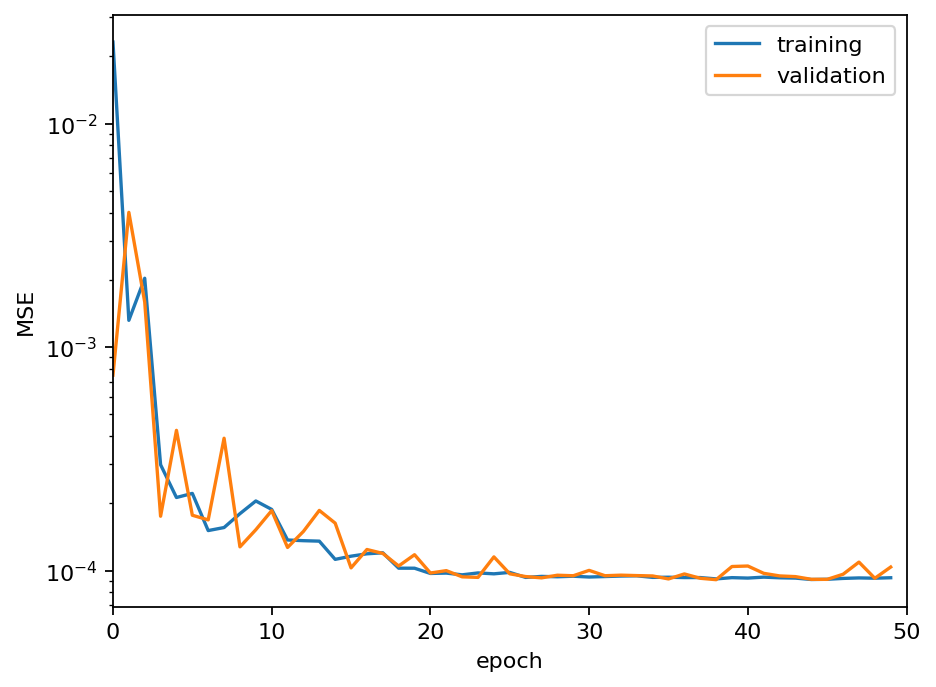

In [32]:
plt.plot(best_results_rad["epoch"], best_results_rad["train_loss"], label="training")
plt.plot(best_results_rad["epoch"], best_results_rad["val_loss"], label="validation")

plt.xlabel("epoch")
plt.ylabel("MSE")
plt.yscale("log")
plt.legend()
plt.xlim(0, 50)
plt.savefig(join(output, "rad_mse_loss.svg"), bbox_inches="tight")

In [33]:
class Rad(pt.nn.Module):
    def __init__(self, model_norm, t_min, t_max, rad_min, rad_max):
        super(Rad, self).__init__()
        self._model = model_norm
        self._t_min = t_min
        self._t_max = t_max
        self._rad_min = rad_min
        self._rad_max = rad_max

    def forward(self, x):
        x_norm = pt.zeros_like(x)
        x_norm[:, 0] = x[:, 0]
        x_norm[:, 1] = (x[:, 1] - self._t_min) / (self._t_max - self._t_min)
        y_norm = self._model(x_norm)
        return (y_norm * (self._rad_max - self._rad_min) + self._rad_min).squeeze()

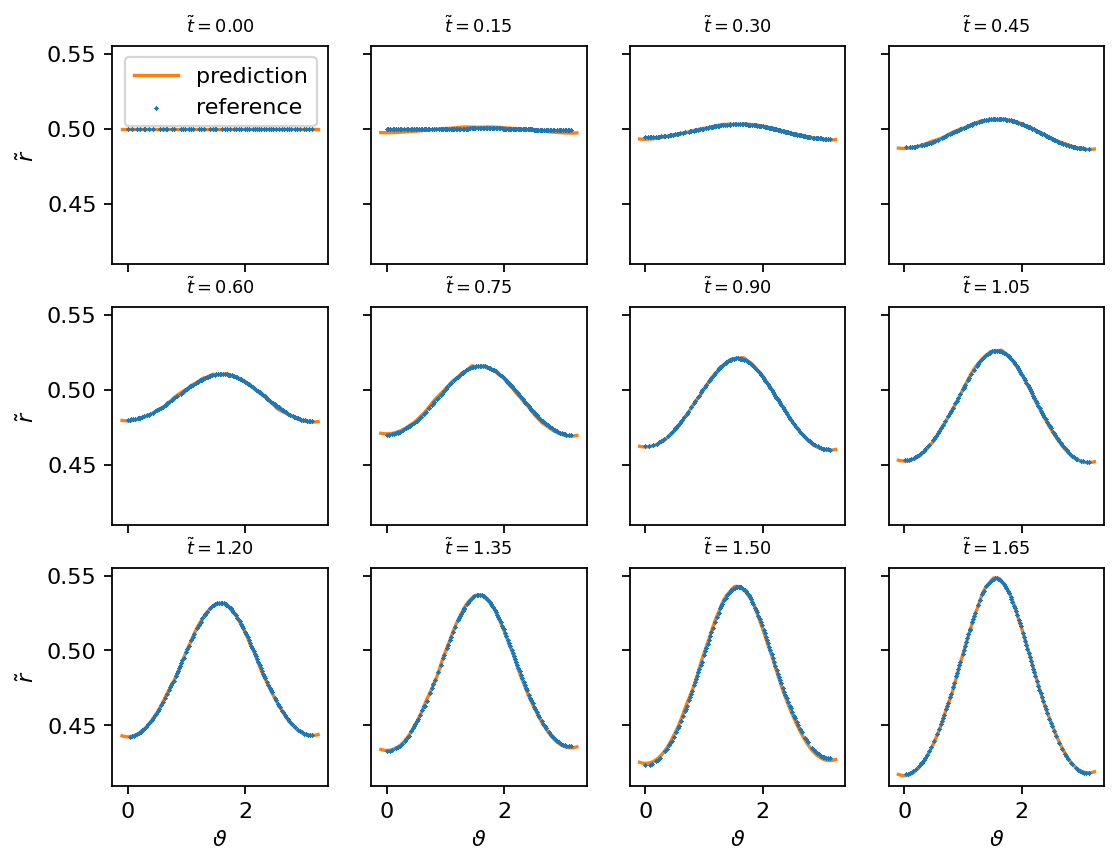

In [34]:
rad_model = Rad(best_rad_model_norm, rad_min[0], rad_max[0], rad_min[1], rad_max[1])
f = pt.zeros(100, 2)
f[:, 0] = pt.linspace(-0.1, np.pi+0.1, 100)
idx = list(range(0, 12, 1))
n_rows = len(idx) / 4 if len(idx) % 4 == 0 else len(idx) / 4 + 1
fig, axarr = plt.subplots(int(n_rows), 4, figsize=(8, n_rows*2), sharex=True, sharey=True)
row, col = 0, 0
for i in idx:
    f[:, 1] = write_times[i]
    r_i = rad_model(f).detach()
    axarr[row, col].plot(f[:, 0], r_i, c="C1", label="prediction")
    axarr[row, col].scatter(shape_polar[i][::4, 1], shape_polar[i][::4, 0], marker="x", s=1, c="C0", zorder=5, label="reference")
    axarr[row, col].set_title(r"$\tilde{t}=" +r"{:2.2f}$".format(write_times[i]), fontsize=8)
    if col == 0 and row == 0: axarr[row, col].legend(loc=0)
    col += 1
    if col % 4 == 0:
        row += 1
        col = 0
for ax in axarr[:, 0]:
    ax.set_ylabel(r"$\tilde{r}$")
for ax in axarr[-1, :]:
    ax.set_xlabel(r"$\vartheta$")
plt.savefig(join(output, "rad_prediction.svg"), bbox_inches="tight")

### Model export

In [35]:
def do_computation_0(a, b):
    return a + b

In [36]:
comp_trace = pt.jit.trace(do_computation_0, example_inputs=(pt.ones(10), pt.ones(10)))
comp_trace.graph

graph(%a : Double(10, strides=[1], requires_grad=0, device=cpu),
      %b : Double(10, strides=[1], requires_grad=0, device=cpu)):
  %2 : int = prim::Constant[value=1]() # /tmp/ipykernel_23891/1867394881.py:2:0
  %3 : Double(10, strides=[1], requires_grad=0, device=cpu) = aten::add(%a, %b, %2) # /tmp/ipykernel_23891/1867394881.py:2:0
  return (%3)

In [37]:
def do_computation_1(a, b, take_abs):
    if take_abs:
        return a.abs() + b.abs()
    else:
        return a + b

In [47]:
try:
    comp_trace = pt.jit.trace(do_computation_1, example_inputs=(pt.ones(10), pt.ones(10), False))
except Exception as e:
    print(e)

Type 'Tuple[Tensor, Tensor, bool]' cannot be traced. Only Tensors and (possibly nested) Lists, Dicts, and Tuples of Tensors can be traced


In [39]:
def do_computation_2(a, b, take_abs=True):
    if take_abs:
        return a.abs() + b.abs()
    else:
        return a + b

In [40]:
comp_trace = pt.jit.trace(do_computation_2, example_inputs=(pt.ones(10), pt.ones(10)))
comp_trace.graph

graph(%a : Double(10, strides=[1], requires_grad=0, device=cpu),
      %b : Double(10, strides=[1], requires_grad=0, device=cpu)):
  %2 : Double(10, strides=[1], requires_grad=0, device=cpu) = aten::abs(%a) # /tmp/ipykernel_23891/2143973957.py:3:0
  %3 : Double(10, strides=[1], requires_grad=0, device=cpu) = aten::abs(%b) # /tmp/ipykernel_23891/2143973957.py:3:0
  %4 : int = prim::Constant[value=1]() # /tmp/ipykernel_23891/2143973957.py:3:0
  %5 : Double(10, strides=[1], requires_grad=0, device=cpu) = aten::add(%2, %3, %4) # /tmp/ipykernel_23891/2143973957.py:3:0
  return (%5)

In [41]:
comp_script = pt.jit.script(do_computation_2, example_inputs=(pt.ones(10), pt.ones(10), True))
comp_script.graph

/home/andre/Development/ml-cfd-lecture/ml-cfd/lib/python3.10/site-packages/torch/jit/_script.py:1280: UserWarning: Warning: monkeytype is not installed. Please install https://github.com/Instagram/MonkeyType to enable Profile-Directed Typing in TorchScript. Refer to https://github.com/Instagram/MonkeyType/blob/master/README.rst to install MonkeyType. 
  warnings.warn("Warning: monkeytype is not installed. Please install https://github.com/Instagram/MonkeyType "


graph(%a.1 : Tensor,
      %b.1 : Tensor,
      %take_abs.1 : Tensor):
  %10 : int = prim::Constant[value=1]()
  %5 : bool = aten::Bool(%take_abs.1) # /tmp/ipykernel_23891/2143973957.py:2:7
  %24 : Tensor = prim::If(%5) # /tmp/ipykernel_23891/2143973957.py:2:4
    block0():
      %7 : Tensor = aten::abs(%a.1) # /tmp/ipykernel_23891/2143973957.py:3:15
      %9 : Tensor = aten::abs(%b.1) # /tmp/ipykernel_23891/2143973957.py:3:25
      %11 : Tensor = aten::add(%7, %9, %10) # /tmp/ipykernel_23891/2143973957.py:3:15
      -> (%11)
    block1():
      %15 : Tensor = aten::add(%a.1, %b.1, %10) # /tmp/ipykernel_23891/2143973957.py:5:15
      -> (%15)
  return (%24)

In [42]:
with pt.no_grad():
    rv_trace = pt.jit.trace(rv_model.eval(), example_inputs=pt.rand(2))
rv_trace.graph

graph(%self.1 : __torch__.RVModel,
      %x : Double(2, strides=[1], requires_grad=0, device=cpu)):
  %_model : __torch__.RVModelNorm = prim::GetAttr[name="_model"](%self.1)
  %39 : int = prim::Constant[value=1]() # /tmp/ipykernel_23891/146180112.py:11:0
  %40 : Double(2, 1, strides=[1, 1], requires_grad=0, device=cpu) = aten::unsqueeze(%x, %39) # /tmp/ipykernel_23891/146180112.py:11:0
  %41 : Double(requires_grad=0, device=cpu) = prim::Constant[value={0}]() # /tmp/ipykernel_23891/146180112.py:11:0
  %42 : int = prim::Constant[value=1]() # /tmp/ipykernel_23891/146180112.py:11:0
  %43 : Double(2, 1, strides=[1, 1], requires_grad=0, device=cpu) = aten::sub(%40, %41, %42) # /tmp/ipykernel_23891/146180112.py:11:0
  %44 : Double(requires_grad=0, device=cpu) = prim::Constant[value={14.85}]() # /tmp/ipykernel_23891/146180112.py:11:0
  %45 : int = prim::Constant[value=1]() # /tmp/ipykernel_23891/146180112.py:11:0
  %46 : Double(requires_grad=0, device=cpu) = aten::sub(%44, %41, %45) # /tmp/ipy

In [43]:
res = rv_trace(pt.linspace(0.0, 5.0, 10, requires_grad=False)).detach()
res

tensor([0.0000, 0.8395, 1.5677, 2.0093, 2.2283, 2.3800, 2.4792, 2.5478, 2.5995,
        2.6395])

In [44]:
rv_trace.save(join(output, "rv_model.pt"))

In [45]:
tv_trace = pt.jit.trace(tv_model, example_inputs=pt.rand((3, 2)))
tv_trace.save(join(output, "tv_model.pt"))

In [46]:
rad_trace = pt.jit.trace(rad_model, example_inputs=pt.rand((3, 2)))
rad_trace.save(join(output, "rad_model.pt"))

## Single-phase flow simulations with mass transfer

## Analyzing the results